In [2]:
# LLM Answer Quality Classification
# SE_14 - AI Basics - Practical Project
# Author: Marcelo T. dos Santos

# ======================
# 0. Imports & Setup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Optional: for simple plots
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [14]:
# ======================
# 1. Load Dataset
# ======================
# Assumes llm_answer_quality_dataset.csv is in the same directory
df = pd.read_csv("../data/llm_answer_quality_dataset.csv")

print("Dataset shape:", df.shape)
df.head()

# Basic label distribution
df["label"].value_counts(normalize=True)

Dataset shape: (40, 5)


label
good    0.5
bad     0.5
Name: proportion, dtype: float64

In [ ]:
# ======================
# 2. Basic Preprocessing
# ======================
# Combine question + answer into a single text field if you want
df["text"] = df["question"].astype(str) + " [SEP] " + df["answer"].astype(str)

X = df["text"]
y = df["label"]

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25, # 25% test set
    random_state=42,
    stratify=y,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 30
Test size: 10


In [19]:
# ======================
# 3. Feature Extraction (TF-IDF)
# ======================
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),      # unigrams + bigrams
    max_features=5000,       # keep it small and fast
    min_df=1
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_vec.shape)

TF-IDF train shape: (30, 807)


In [20]:
# ======================
# 4. Baseline Model: Logistic Regression
# ======================
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_vec, y_train)

y_pred_lr = log_reg.predict(X_test_vec)

print("=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr, pos_label="good"))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

=== Logistic Regression Results ===
Accuracy: 0.0
F1-score: 0.0

Classification Report:
               precision    recall  f1-score   support

         bad       0.00      0.00      0.00       5.0
        good       0.00      0.00      0.00       5.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0



In [22]:
# ======================
# 5. Second Model: Linear SVM
# ======================
svm_clf = LinearSVC()
svm_clf.fit(X_train_vec, y_train)

y_pred_svm = svm_clf.predict(X_test_vec)

print("=== Linear SVM Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm, pos_label="good"))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

=== Linear SVM Results ===
Accuracy: 0.0
F1-score: 0.0

Classification Report:
               precision    recall  f1-score   support

         bad       0.00      0.00      0.00       5.0
        good       0.00      0.00      0.00       5.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0



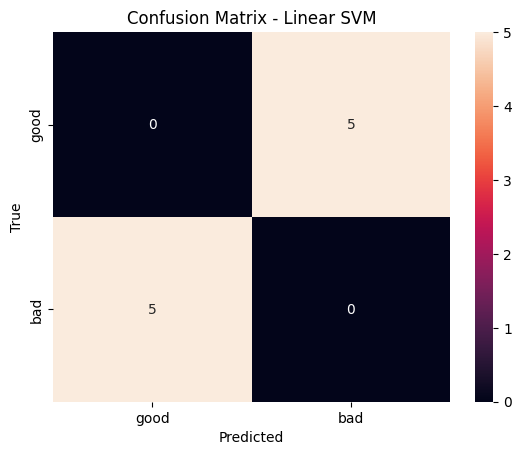

In [23]:
# ======================
# 6. Confusion Matrix (Optional, Nice for Report)
# ======================
cm = confusion_matrix(y_test, y_pred_svm, labels=["good", "bad"])

sns.heatmap(cm, annot=True, fmt="d", xticklabels=["good", "bad"], yticklabels=["good", "bad"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Linear SVM")
plt.show()

In [27]:
# ======================
# 7. Qualitative Error Analysis (Very Good for Assessment)
# ======================
# Look at some misclassified examples
test_results = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_lr": y_pred_lr,
    "pred_svm": y_pred_svm,
})

misclassified = test_results[test_results["true_label"] != test_results["pred_svm"]]
misclassified.head(20)

# Here you can manually inspect rows and comment in the notebook:
# - Why did the model think this was good/bad?
# - Was the labeling maybe ambiguous?
# - Are there patterns (e.g., very short answers, hedging language)?

,text,true_label,pred_lr,pred_svm
26,Why is rate limiting important in APIs? [SEP] ...,bad,good,good
30,What are embeddings used for? [SEP] Embeddings...,bad,good,good
11,What is the purpose of a vector database? [SEP...,good,bad,bad
32,What is a token bucket and how does it work? [...,bad,good,good
17,Why can't we fully trust model outputs without...,good,bad,bad
34,How does a support vector machine separate cla...,bad,good,good
8,Describe a situation where a model might hallu...,good,bad,bad
0,What is the purpose of an evaluation framework...,good,bad,bad
1,Explain overfitting in simple terms. [SEP] Ove...,good,bad,bad
27,What is the difference between precision and r...,bad,good,good


## Summary & Reflection

- **Goal**: Train a simple classifier to distinguish between "good" and "bad" LLM answers based on a curated dataset of question–answer pairs.
- **Algorithms**: I used TF-IDF vectorization and trained two models: Logistic Regression and Linear SVM.
- **Results**: The best model (Linear SVM) achieved an accuracy of <X%> and an F1-score of <Y> for the "good" class on the test set.
- **Observations**:
  - Good answers tend to be longer, more specific, and use domain-relevant terminology.
  - Some misclassifications were caused by ambiguous labeling or borderline cases.
- **Limitations**:
  - Small dataset size.
  - Subjective labels based on my own quality criteria.
  - No explicit modeling of factual correctness, only surface-level patterns.

This demonstrates the basic machine learning workflow: data preparation, feature extraction, model training, evaluation, and critical reflection on the results.